In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [14]:
# Importing Libraries
import numpy as np
import string
from pickle import dump
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.layers import Layer
from keras.layers import Input, Dense, LSTM, Embedding
import keras.backend as K
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import gpt_2_simple as gpt2
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

In [ ]:
# load document
in_filename = '/content/drive/MyDrive/Colab Notebooks/Text Generation/republic_clean.txt'
doc = load_doc(in_filename)
print(doc[:200])

The Project Gutenberg EBook of The Republic, by Plato

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it u


## Cleaning Text

*   Replace ‘–‘ with a white space so we can split words better.
*   Split words based on white space.
*   Remove all punctuation from words to reduce the vocabulary size (e.g. ‘What?’ becomes ‘What’).
*   Remove all words that are not alphabetic to remove standalone punctuation tokens.
*   Normalize all words to lowercase to reduce the vocabulary size.









In [ ]:
# turn a doc into clean tokens
def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens

In [ ]:
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'republic', 'by', 'plato', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 'reuse', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'wwwgutenbergorg', 'title', 'the', 'republic', 'author', 'plato', 'translator', 'b', 'jowett', 'posting', 'date', 'august', 'ebook', 'release', 'date', 'october', 'last', 'updated', 'june', 'language', 'english', 'start', 'of', 'this', 'project', 'gutenberg', 'ebook', 'the', 'republic', 'produced', 'by', 'sue', 'asscher', 'the', 'republic', 'by', 'plato', 'translated', 'by', 'benjamin', 'jowett', 'note', 'the', 'republic', 'by', 'plato', 'jowett', 'etext', 'introduction', 'and', 'analysis', 'the', 'republic', 'of', 'plato', 'is', 'the', 'longest', 'of', 'hi

In [ ]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
	# select sequence of tokens
	seq = tokens[i-length:i]
	# convert into a line
	line = ' '.join(seq)
	# store
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 216740


In [ ]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [ ]:
# save sequences to file
out_filename = '/content/drive/MyDrive/Colab Notebooks/Text Generation/republic_sequences.txt'
save_doc(sequences, out_filename)

In [ ]:
in_filename = '/content/drive/MyDrive/Colab Notebooks/Text Generation/republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [ ]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
# vocabulary size to handle zero offset in arrays while passing the sequence to Embedding Layer
vocab_size = len(tokenizer.word_index) 

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [ ]:
# separate into input and output
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size,dtype='int8')
seq_length = X.shape[1]

In [ ]:

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
inputs = Input(length-1)
embedding_layer = Embedding(vocab_size + 1, 50)(inputs)
lstm_1 = LSTM(100, return_sequences=True,activation='tanh')(embedding_layer)
lstm_2 = LSTM(100, return_sequences=True,activation='tanh')(lstm_1)
attention_layer = attention()(lstm_2)
dense_1 = Dense(100,activation='relu')(attention_layer)
outputs = Dense(vocab_size,trainable = True,activation='softmax')(dense_1)
model = Model(inputs,outputs)
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            522750    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 attention (attention)       (None, 100)               150       
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 10454)             105585

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/Text Generation/model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(X,
         y,
         epochs = 50,
         batch_size = 128,
         callbacks = callbacks_list,
         verbose = 1)

1693/1694 [============================>.] - ETA: 0s - loss: 2.4737 - accuracy: 0.4442
Epoch 00048: loss improved from 2.51892 to 2.47372, saving model to /content/drive/MyDrive/Colab Notebooks/Text Generation/model_2_weights.hdf5
1694/1694 [==============================] - 63s 37ms/step - loss: 2.4737 - accuracy: 0.4442
Epoch 49/50
1694/1694 [==============================] - ETA: 0s - loss: 2.4373 - accuracy: 0.4498
Epoch 00049: loss improved from 2.47372 to 2.43728, saving model to /content/drive/MyDrive/Colab Notebooks/Text Generation/model_2_weights.hdf5
1694/1694 [==============================] - 63s 37ms/step - loss: 2.4373 - accuracy: 0.4498
Epoch 50/50
1693/1694 [============================>.] - ETA: 0s - loss: 2.3994 - accuracy: 0.4560
Epoch 00050: loss improved from 2.43728 to 2.39953, saving model to /content/drive/MyDrive/Colab Notebooks/Text Generation/model_2_weights.hdf5
1694/1694 [==============================] - 63s 37ms/step - loss: 2.3995 - accuracy: 0.4560


Let's train for 50 more epochs.

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Text Generation/model',save_format='tf')
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Text Generation/model')

In [ ]:
# Removed the logS
history_loaded_model = loaded_model.fit(X,
         y,
         epochs = 50,
         batch_size = 128,
         callbacks = callbacks_list,
         verbose = 1)

In [ ]:
loaded_model.save('/content/drive/MyDrive/Colab Notebooks/Text Generation/model.hdf5')

With training complete, we now have a model that can generate text. However, we need to give it a starting point. To do this, we write a function that takes a string input, tokenizes it, then pads it with zeroes so it fits into our 50 long prediction window.

In [ ]:
def gen(model,seq,max_len = 50):
    ''' Generates a sequence given a string seq using specified model until the total sequence length
    reaches max_len'''
    # Tokenize the input string
    tokenized_sent = tokenizer.texts_to_sequences([seq])
    max_len = max_len+len(tokenized_sent[0])
    # If sentence is not as long as the desired sentence length, we need to 'pad sequence' so that
    # the array input shape is correct going into our LSTM. the `pad_sequences` function adds 
    # zeroes to the left side of our sequence until it becomes 50 long, the number of input features.
    while len(tokenized_sent[0]) < max_len:
        padded_sentence = pad_sequences(tokenized_sent[-50:],maxlen=50)
        op = model.predict(np.asarray(padded_sentence).reshape(1,-1))
        tokenized_sent[0].append(op.argmax()+1)
        
    return " ".join(map(lambda x : reverse_word_map[x],tokenized_sent[0]))

In [ ]:
final_model = load_model('/content/drive/MyDrive/Colab Notebooks/Text Generation/model.hdf5',
                         custom_objects={'attention': attention})

In [ ]:
seq = 'When we had finished our prayers and viewed the spectacle we turned in the direction of the city'

gen(final_model,seq)

'when we had finished our prayers and viewed the spectacle we turned in the direction of the city would i or birth yes other as i true true i true what as by from history would which which lives injustice lives is of speaking said have was have manners grows citizens yes that in never so so with understand yes that in soul but arranged for of for'

In [ ]:
seq_1 = 'Certainly we will, said Glaucon; and in a few minutes Polemarchus appeared, and with him Adeimantus, Glaucon’s brother, Niceratus the son of Nicias, and several'

gen(final_model,seq_1)

'certainly we will said glaucon and in a few minutes polemarchus appeared and with him adeimantus brother niceratus the son of nicias and several rolling to children but i true true you yes or question by men by men be or is or is or began is sensible said a feast like differently to of he into from honoured not survive have interposing was of of state their supposed to of of reflect i years'

In [ ]:
seq_2 = 'The servant took hold of me by the cloak behind'

gen(final_model,seq_2)

'the servant took hold of me by the cloak behind i with word true that only what but but i reason and lives call from who i true but i lives by for going is would is by was of was is is makes of friends is begins is else he injustice injustice this making not he pleasures cp of for'

In [ ]:
seq_3 = 'The argument of the Republic is the search after Justice, the nature of which is first hinted at by Cephalus, the just and blameless old man'

gen(final_model,seq_3)

'the argument of the republic is the search after justice the nature of which is first hinted at by cephalus the just and blameless old man about from from he that that that company what certainly we so whom so what but what in just only making of of state of of for passed be is is public principles by by soul of for friend of he grow a sounds is value their step from of state'

While it doesn’t make the most sense, it actually seems readable. Given a larger set of training data, this approach and model can be used to generate much more understandable text (most likely with some parameter tweaking, of course).

Let's try to fine tune gpt2 small and see the results

In [ ]:
gpt2.download_gpt2(model_name='124M')

Fetching checkpoint: 1.05Mit [00:00, 305Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 7.40Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 254Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:21, 22.7Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 484Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 9.97Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 8.43Mit/s]


In [ ]:
session = gpt2.start_tf_sess()
gpt2.finetune(sess=session,
              dataset = in_filename,
              model_name = '124M',
              steps = 100,
              restore_from = 'fresh',
              run_name = 'run1',
              print_every = 10,
              sample_every = 20,
              save_every = 20
            )

======== SAMPLE 1 ========
 be the best and the most reasonable.
the best at any rate is the least he thinks and most is the best
best at any rate is the least he thinks and most is the most sensible and most
at any rate is the least he thinks and most is the best and the most reasonable but
any rate is the least he thinks and most is the most sensible and most reasonable but the
rate is the least he thinks and most is the most sensible and most reasonable but the most
is the least he thinks and most is the most sensible and most reasonable but the most irrational
the least he thinks and most is the most sensible and most reasonable but the most irrational he
most seems to be the best and the most reasonable but the most irrational he is
says and most is the most sensible and most reasonable but the most irrational he is the
and most is the most sensible and most reasonable but the most irrational he is the most
most is the most sensible and most reasonable but the most irrational he i

In [ ]:
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

In [3]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1')
session = gpt2.start_tf_sess()
gpt2.load_gpt2(session, run_name='run1')

Loading checkpoint checkpoint/run1/model-100
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-100


In [ ]:
seq = 'When we had finished our prayers and viewed the spectacle we turned in the direction of the city'

gpt2.generate(session,
              length = 50,
              temperature = 0.7,
              prefix = seq,
              nsamples = 1,
              batch_size = 1,
              
              )

When we had finished our prayers and viewed the spectacle we turned in the direction of the city where there was a long way to go and the plato said
the fullness of the world is a mystery which is impossible to be explained by any mathematical formula let us maintain that there is no such thing as a truth in philosophy for all the


In [ ]:
seq_1 = 'Certainly we will, said Glaucon; and in a few minutes Polemarchus appeared, and with him Adeimantus, Glaucon’s brother, Niceratus the son of Nicias, and several'

gpt2.generate(session,
              length = 50,
              temperature = 0.7,
              prefix = seq_1,
              nsamples = 1,
              batch_size = 1,
              
              )

Certainly we will, said Glaucon; and in a few minutes Polemarchus appeared, and with him Adeimantus, Glaucon’s brother, Niceratus the son of Nicias, and several other friends of the two states were quite right in the words of the poet Lucias of Metaphysics
they were the first and most important, but now their enemies are the second and third and fourth states and on the whole of them that is


In [ ]:
seq_2 = 'The servant took hold of me by the cloak behind'

gpt2.generate(session,
              length = 50,
              temperature = 0.7,
              prefix = seq_2,
              nsamples = 1,
              batch_size = 1,
              
              )

The servant took hold of me by the cloak behind me and began to beat me according to the laws of the city and the other men were beating me like flies and trying to take me from my place as a slave and then they said to me that my master was a pig and therefore the servant should


In [ ]:
seq_3 = 'The argument of the Republic is the search after Justice, the nature of which is first hinted at by Cephalus, the just and blameless old man'

gpt2.generate(session,
              length = 50,
              temperature = 0.7,
              prefix = seq_3,
              nsamples = 1,
              batch_size = 1,
              
              )

The argument of the Republic is the search after Justice, the nature of which is first hinted at by Cephalus, the just and blameless old man the unjust and the unjust will not have a share in the
the argument of the republic is the search after Justice, the nature of which is first hinted at by Cephalus the unjust will not have a share in the law and the unjust


In [ ]:
SEED = np.random.seed(25)
dataframe = pd.DataFrame(columns=['input sequence','next following sequence','bleu score (custom model)','bleu score (GPT-2)'])
input_seqs = []
next_seqs = []
for i in range(100):
  pos = np.random.randint(0,len(lines)-50)
  input_seq = ' '.join(lines[pos].split()[:-1])
  input_seqs.append(input_seq)
  next_seq = ' '.join(lines[pos + 50].split()[:-1])
  next_seqs.append(next_seq)

dataframe['input sequence']   = input_seqs
dataframe['next following sequence'] = next_seqs
dataframe

,input sequence,next following sequence,bleu score (custom model),bleu score (GPT-2)
0,started originally with the division of labour...,a man is out of his depth whether in a pool or...,NaN,NaN
1,world as dark the spectator of all time and of...,remote past on which his eye could rest nor an...,NaN,NaN
2,the timaeus when the rhetorical advantage of r...,nor are we informed whether in the evening the...,NaN,NaN
3,lost dialogues of aristotle as he himself tell...,dialogue but if he is defective in form much m...,NaN,NaN
4,said and knowing this they are quite right in ...,friend certainly not neither would you approve...,NaN,NaN
...,...,...,...,...
95,which defines and explains the essence or bein...,his grave before his is well waked up and woul...,NaN,NaN
96,arithmetician or grammarian at the time when h...,person of skill ever makes a mistake in so far...,NaN,NaN
97,as a false conception of knowledge for example...,termed is based upon a sound judgment for mank...,NaN,NaN
98,of rank the son of the rich must descend and t...,the present generation but in the next perhaps...,NaN,NaN


In [ ]:
s0 = dataframe['input sequence'][0]
print('Input Sentence : {}'.format(s0))
t0 = gen(final_model,s0)
a0 = dataframe['next following sequence'][0]
print('Actual Next Sentence : {}'.format(a0))
split_a0 = a0.split()
split_t0 = t0.split()[50:]
print('Predicted Next Sentence : {}'.format(' '.join(split_t0)))
print('Bleu Score : ',sentence_bleu(split_a0,split_t0))

Input Sentence : started originally with the division of labour and the diversity of employments was based on the difference of natures but is there no difference between men and women nay are they not wholly different there was the difficulty glaucon which made me unwilling to speak of family relations however when
Actual Next Sentence : a man is out of his depth whether in a pool or in an ocean he can only swim for his life and we must try to find a way of escape if we can the argument is that different natures have different uses and the natures of men and
Predicted Next Sentence : he in these doubts that of governs greater logic of husbands servants in not away have he souls understanding be he this because that only only hour seeming may which which you we worse is toils is is is square of state is is is is extended is home a
Bleu Score :  0.3760603093086394


In [ ]:
gpt2_s0 = dataframe['input sequence'][0]
print('Input Sentence : {}'.format(gpt2_s0))
gpt2_t0 = gpt2.generate(session,
              length = 50,
              temperature = 0.7,
              prefix = gpt2_s0,
              nsamples = 1,
              batch_size = 1,
              return_as_list  =True
              )[0]
gpt2_a0 = dataframe['next following sequence'][0] 
print('Actual Next Sentence : {}'.format(gpt2_a0))             
gpt2_split_a0 = gpt2_a0.split()
gpt2_split_t0 = gpt2_t0.split()[50:]
print('Predicted Next Sentence : {}'.format(' '.join(gpt2_split_t0)))
sentence_bleu(gpt2_split_a0,gpt2_split_t0)

Input Sentence : started originally with the division of labour and the diversity of employments was based on the difference of natures but is there no difference between men and women nay are they not wholly different there was the difficulty glaucon which made me unwilling to speak of family relations however when
Actual Next Sentence : a man is out of his depth whether in a pool or in an ocean he can only swim for his life and we must try to find a way of escape if we can the argument is that different natures have different uses and the natures of men and
Predicted Next Sentence : i had been educated i was determined to be a liberal a modern education was certainly not the true origin of the republic the young men who had been educated by the old oleknic aristocrats and were now in the middle ages were in time


0.4591497693322866

In [ ]:
s3 = dataframe['input sequence'][3]
print('Input Sentence : {}'.format(s3))
t3 = gen(final_model,s3)
a3 = dataframe['next following sequence'][3]
print('Actual Next Sentence : {}'.format(a3))
split_a3 = a3.split()
split_t3 = t3.split()[50:]
print('Predicted Next Sentence : {}'.format(' '.join(split_t3)))
print('Bleu Score : ',sentence_bleu(split_a3,split_t3))

Input Sentence : lost dialogues of aristotle as he himself tells us or of plato to which they bear many superficial resemblances he is still the roman orator he is not conversing but making speeches and is never able to mould the intractable latin to the grace and ease of the greek platonic
Actual Next Sentence : dialogue but if he is defective in form much more is he inferior to the greek in matter he nowhere in his philosophical writings leaves upon our minds the impression of an original thinker platos republic has been said to be a church and not a state and such an
Predicted Next Sentence : attained a actual filling his hundred like of of of of of of of of of of of of for of of of of despise he will any rule man are he are man if he and and enough he in these assassination in youth taking of for of come
Bleu Score :  0.3760603093086394


In [ ]:
gpt2_s3 = dataframe['input sequence'][3]
print('Input Sentence : {}'.format(gpt2_s3))
gpt2_t3 = gpt2.generate(session,
              length = 50,
              temperature = 0.7,
              prefix = gpt2_s3,
              nsamples = 1,
              batch_size = 1,
              return_as_list  =True
              )[0]
gpt2_a3 = dataframe['next following sequence'][0] 
print('Actual Next Sentence : {}'.format(gpt2_a3))             
gpt2_split_a3 = gpt2_a3.split()
gpt2_split_t3 = gpt2_t3.split()[50:]
print('Predicted Next Sentence : {}'.format(' '.join(gpt2_split_t3)))
sentence_bleu(gpt2_split_a3,gpt2_split_t3)

Input Sentence : lost dialogues of aristotle as he himself tells us or of plato to which they bear many superficial resemblances he is still the roman orator he is not conversing but making speeches and is never able to mould the intractable latin to the grace and ease of the greek platonic
Actual Next Sentence : a man is out of his depth whether in a pool or in an ocean he can only swim for his life and we must try to find a way of escape if we can the argument is that different natures have different uses and the natures of men and
Predicted Next Sentence : virtues he is a philologist and the sciences he says are corrupting and corrupting the soul and the divine dialogue of aristotle as he himself tells us or of plato to which they bear many superficial resemblances he is still the


0.3951882613244048

In [ ]:
scores_custom = []
for i in range(100):
  inp_seq = dataframe['input sequence'][i]
  predict_next_seq = gen(final_model,inp_seq)
  actual_next_seq = dataframe['next following sequence'][i]  
  split_actual = actual_next_seq.split()
  split_predicted = predict_next_seq.split()[50:]
  score = sentence_bleu(split_actual,split_predicted)
  scores_custom.append(score)

dataframe['bleu score (custom model)'] = scores_custom
dataframe.to_csv('/content/drive/MyDrive/Colab Notebooks/Text Generation/dataframe.csv')
dataframe

,input sequence,next following sequence,bleu score (custom model),bleu score (GPT-2)
0,started originally with the division of labour...,a man is out of his depth whether in a pool or...,0.376060,NaN
1,world as dark the spectator of all time and of...,remote past on which his eye could rest nor an...,0.376060,NaN
2,the timaeus when the rhetorical advantage of r...,nor are we informed whether in the evening the...,0.447214,NaN
3,lost dialogues of aristotle as he himself tell...,dialogue but if he is defective in form much m...,0.376060,NaN
4,said and knowing this they are quite right in ...,friend certainly not neither would you approve...,0.000000,NaN
...,...,...,...,...
95,which defines and explains the essence or bein...,his grave before his is well waked up and woul...,0.447214,NaN
96,arithmetician or grammarian at the time when h...,person of skill ever makes a mistake in so far...,0.000000,NaN
97,as a false conception of knowledge for example...,termed is based upon a sound judgment for mank...,0.494923,NaN
98,of rank the son of the rich must descend and t...,the present generation but in the next perhaps...,0.494923,NaN


In [13]:
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text Generation/dataframe.csv')
dataframe.drop(columns=['Unnamed: 0'],inplace=True)
scores_gpt2 =[]
gpt2.copy_checkpoint_from_gdrive(run_name='run1')
session = gpt2.start_tf_sess()
gpt2.load_gpt2(session, run_name='run1',reuse=True)
j = range(0,100)

for i in j:
  globals()['inp_seq_' + str(i)] = dataframe['input sequence'][i]
  globals()['predict_next_seq' + str(i)] = gpt2.generate(session,
                                    length = 50,
                                    temperature = 0.7,
                                    prefix = globals()['inp_seq_' + str(i)],
                                    nsamples = 1,
                                    batch_size = 1,
                                    return_as_list  =True
                                  )[0]
  globals()['actual_next_seq' + str(i)] = dataframe['next following sequence'][i]
  globals()['split_actual' + str(i)] = globals()['actual_next_seq' + str(i)].split()
  globals()['split_predicted' + str(i)] = globals()['predict_next_seq' + str(i)].split()[50:]
  globals()['score' + str(i)] = sentence_bleu(globals()['split_actual' + str(i)],globals()['split_predicted' + str(i)])
  scores_gpt2.append(globals()['score' + str(i)] )

dataframe['bleu score (GPT-2)'] = scores_gpt2
dataframe

,input sequence,next following sequence,bleu score (custom model),bleu score (GPT-2)
0,started originally with the division of labour...,a man is out of his depth whether in a pool or...,0.376060,0.388273
1,world as dark the spectator of all time and of...,remote past on which his eye could rest nor an...,0.376060,0.454185
2,the timaeus when the rhetorical advantage of r...,nor are we informed whether in the evening the...,0.447214,0.000000
3,lost dialogues of aristotle as he himself tell...,dialogue but if he is defective in form much m...,0.376060,0.000000
4,said and knowing this they are quite right in ...,friend certainly not neither would you approve...,0.000000,0.502639
...,...,...,...,...
95,which defines and explains the essence or bein...,his grave before his is well waked up and woul...,0.447214,0.379918
96,arithmetician or grammarian at the time when h...,person of skill ever makes a mistake in so far...,0.000000,0.397635
97,as a false conception of knowledge for example...,termed is based upon a sound judgment for mank...,0.494923,0.454185
98,of rank the son of the rich must descend and t...,the present generation but in the next perhaps...,0.494923,0.379918


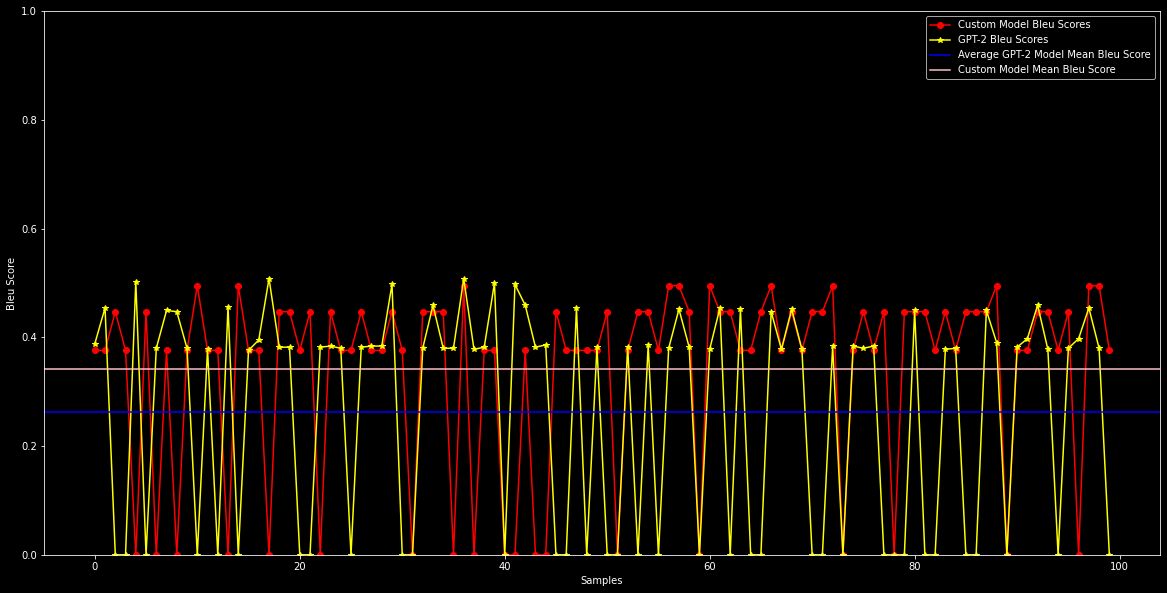

In [26]:
x_range = range(100)
custom_Bleu = np.array(dataframe['bleu score (custom model)'])
gpt2_Blue = np.array(dataframe['bleu score (GPT-2)'])
plt.figure(figsize = (20,10))
plt.style.use('dark_background')
plt.plot(x_range,custom_Bleu,marker = 'o',color = 'red')
plt.plot(x_range,gpt2_Blue,marker = '*',color = 'yellow')
plt.axhline(gpt2_Blue.mean(),color = 'blue')
plt.axhline(custom_Bleu.mean(),color = 'pink')
plt.ylabel('Bleu Score')
plt.xlabel('Samples')
plt.ylim([0,1])
plt.legend(['Custom Model Bleu Scores','GPT-2 Bleu Scores','Average GPT-2 Model Mean Bleu Score','Custom Model Mean Bleu Score'],loc = 1)
plt.show()